# Pulsebuilding for QCoDeS part I

This set of tutorials covers the offline construction of pulse sequences from idea to numpy array to awg file. No instrument is required. In part one, we deal with individual pulse sequence elements. Part two covers sequences and awg files. 

## Lingo

Let's settle on a vocabulary. At the highest level, we construct **elements**. These elements will eventually become sequence elements of the AWG 5014 sequencer and can thus consist of different **subelements** corresponding to different channels of the AWG (or several AWGs). Each subelement consists of some number of **segments** (e.g. a ramp, a sine of a certain frequence, a pi-pulse, etc).

There is no reason to maintain a very clear distinction between subelements and elements, since a subelement becomes an element in the case of a single-channel element, and all subelements are in any case independent. For the remainder of this tutorial, we only refer to elements.

## Code abstractions

The pulse building module uses the concept of a **blueprint** which is eventually **forged** into an element. The blueprint is basically a list of segments; this is where the user specifies that "first comes a ramp, then a sine, then another ramp, ...". The forging into an element happens when the user provides the **durations** of the segments. 

## Code implementation

Each segment is either **special** or normal. 

### Normal segments

A normal segment consists of a _unique_ name, a function object, a tuple of arguments to the function, and an optional number of **timesteps**. 

 * The name: can be provided by the user or omitted. If omitted, the segment will get the name of its function. Since all names must be unique, the blueprint _appends numbers_ to names if they occur more than once. The numbers are appended chronologically throughout the blueprint. See example below. Note that valid input (base) names are strings NOT ending in a number. Thus, 'pi/2pulse' is valid, whereas 'pulsepi/2' is not.
 
 * The function: must be a python function taking at least two arguments; the sample rate and the segment duration. If the function takes other arguments (such as ramp slope, frequency, etc.) sample rate and duration arguments must be the last positional arguments. Keyword arguments are currently not allowed. See example at the very end.
 
 * The arguments: are in a tuple of $n-2$ arguments for a function taking $n$ arguments, i.e. specifying everything but the sample rate and duration.
 
 * The number of timesteps: can be 1 (default) or more. This is needed if a segment on one channel is to last while several different segments are run through on another channel of the same element. See example below.


### Special segments

A special segment has a (protected) name and a number of arguments. So far, two special segments are implemented.
 
 * `waituntil`, args [time (int)]:  When put in a blueprint, this function ensures that the _next_ segment starts at the absolute time `time` after the start of the element. It does so by filling any excess time with zeros. It fails if the previous segment will finish after time `time`.
 
 * `makemeanfit`. Not implemented yet.

Let's go!

In [1]:
%matplotlib nbagg
import qcodes.instrument_drivers.tektronix.pulsebuilding as pb
import numpy as np
import matplotlib.pyplot as plt

## Basic blueprinting

In [2]:
# The pulsebuilding module comes with a (small) collection of functions appropriate for being segments.
ramp = pb.PulseAtoms.ramp  # args: slope, offset
sine = pb.PulseAtoms.sine  # args: freq, ampl, off

# make a blueprint

# The blueprint takes three (the fourth optional) lists as input
bp1 = pb.BluePrint([ramp, sine, ramp],  # functions
                   [(-1, 0), (5, 1, 1), (2, 0)],  # arguments
                   ['', 'wiggle', ''],  # names
                   [1, 2, 1])  # (optional) timesteps

# The blueprint can be inspected
bp1.showPrint()

Segment 1: ramp, <function PulseAtoms.ramp at 0x10d1af510>, (-1, 0), 1
Segment 2: wiggle, <function PulseAtoms.sine at 0x10d1af488>, (5, 1, 1), 2
Segment 3: ramp2, <function PulseAtoms.ramp at 0x10d1af510>, (2, 0), 1


In [3]:
# Alternatively, one construct a blueprint by adding segments one-by-one
bp2 = pb.BluePrint([], [], [])
bp2.insertSegment(-1, ramp, (-1, 0))
bp2.insertSegment(-1, sine, (5, 1, 1), 'wiggle', 2)
bp2.insertSegment(-1, ramp, (2, 0))

# This achieves the same as the code above, as we may conclude by inspection...
bp2.showPrint()
# ... or by direct comparison
print('---')
print(bp1==bp2)

Segment 1: ramp, <function PulseAtoms.ramp at 0x10d1af510>, (-1, 0), 1
Segment 2: wiggle, <function PulseAtoms.sine at 0x10d1af488>, (5, 1, 1), 2
Segment 3: ramp2, <function PulseAtoms.ramp at 0x10d1af510>, (2, 0), 1
---
True


In [4]:
bp1.length_timesteps

3

In [5]:
bp1 = pb.BluePrint([ramp, sine, ramp],  # functions
                   [(-1, 0), (5, 1, 1), (2, 0)],  # arguments
                   ['', 'wiggle', ''],  # names
                   [1, 2, 1],
                   durations = [4, 4, 4, 4])  # (optional) timesteps

In [6]:
bp1._durslist

[(4,), (4, 4), (4,)]

In [7]:
# It is also possible to copy blueprints
bp3 = bp1.copy()
print('Are bp1 and bp3 identical?', bp3==bp1)

# Let's say we now want to modify bp3 to have no sine function but only ramps
bp3.removeSegment('wiggle')  # remove the offending segment
bp3.insertSegment(1, ramp, (1, 0))  # insert a ramp before element 1 (the second element)
bp3.insertSegment(2, ramp, (0, 0))  # insert a ramp

# And let's say that we want to change the frequency of the sine of bp2
# we can adress the argument by its position...
bp2.changeArg('wiggle', 0, 2.5)
# ...or by its name (even though it's NOT a keyword argument)
bp2.changeArg('wiggle', 'freq', 2.5)

# Of course, the blueprints differ now
print('Are bp2 and bp3 still identical?', bp3==bp1)

Are bp1 and bp3 identical? True
Are bp2 and bp3 still identical? False


In [8]:
# It can be useful to add two blueprints together
bp4 = pb.BluePrint([ramp], [(1, 0)], [''])
bp5 = bp4.copy()
for ii in range(3):
    bp4.showPrint()
    print('--')
    bp4 += bp5

Segment 1: ramp, <function PulseAtoms.ramp at 0x10d1af510>, (1, 0), 1
--
Segment 1: ramp, <function PulseAtoms.ramp at 0x10d1af510>, (1, 0), 1
Segment 2: ramp2, <function PulseAtoms.ramp at 0x10d1af510>, (1, 0), 1
--
Segment 1: ramp, <function PulseAtoms.ramp at 0x10d1af510>, (1, 0), 1
Segment 2: ramp2, <function PulseAtoms.ramp at 0x10d1af510>, (1, 0), 1
Segment 3: ramp3, <function PulseAtoms.ramp at 0x10d1af510>, (1, 0), 1
--


In [9]:
# And of course, at some point we would like to add markers
# The markers are zero by default.
# The marker is specified as a list of tuples. The first number is the absolute time at which to turn on,
# the second is the duration until the marker turns off again
bp2.marker1 = [(1, 0.1), (2, 1)]
bp2.marker2 = [(1.1, 0.9), (3, 1)]

## Forging and plotting

<IPython.core.display.Javascript object>


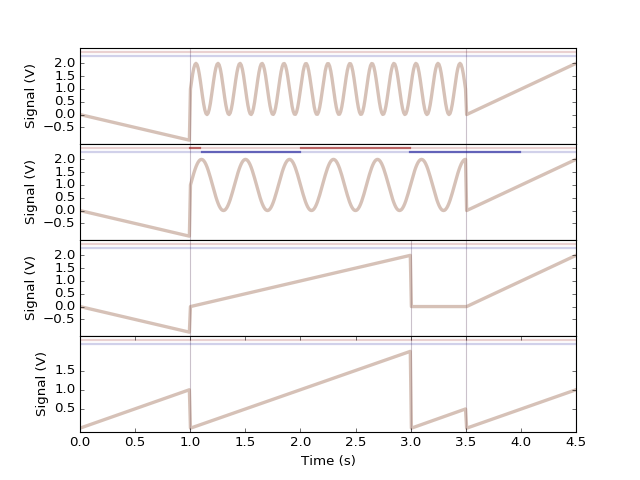

In [10]:
# Finally, we may provide a sample rate and durations and plot and forge the segments
durations = [1, 2, 0.5, 1]
SR = 100

# plot, see that everything we did above makes sense
pb.bluePrintPlotter([bp1, bp2, bp3, bp4], 100, durations)

# The two lines above the waveform represent marker1 (red) and marker2 (blue), respectively

Help on function elementBuilder in module qcodes.instrument_drivers.tektronix.pulsebuilding:

elementBuilder(blueprints, SR, durations, channels=None, returnnewdurs=False)
    Forge blueprints into an element
    
    Args:
        blueprints (Union[BluePrint, list]): A single blueprint or a list of
            blueprints.
        SR (int): The sample rate (Sa/s)
        durations (list): List of durations or a list of lists of durations
            if different blueprints have different durations. If a single list
            is given, this list is used for all blueprints.
        channels (Union[list, None]): A list specifying the channels of the
            blueprints in the list. If None, channels 1, 2, .. are assigned
        returnnewdurs (bool): If True, the returned dictionary contains the
            newdurations.
    
    Returns:
        dict: Dictionary with channel numbers (ints) as keys and forged
            blueprints as values. A forged blueprint is a numpy array
     

<IPython.core.display.Javascript object>


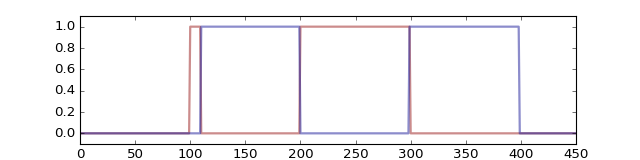

(-0.1, 1.1)

In [11]:
# Forging is very similar to plotting
element = pb.elementBuilder(bp2, SR, durations)

# the elementBuilder returns the element as a dictionary. The docstring explains everything
help(pb.elementBuilder)

multichannelelement = pb.elementBuilder([bp1, bp2], SR, durations, channels=[1, 3])
plt.figure(figsize=(8, 2))
plt.plot(multichannelelement[3][1], lw=2, color=(0.6, 0.1, 0.1), alpha=0.5)
plt.plot(multichannelelement[3][2], lw=2, color=(0.1, 0.1, 0.6), alpha=0.5)
plt.ylim([-0.1, 1.1])

## More advanced examples

### Multiple argument replacement

<IPython.core.display.Javascript object>


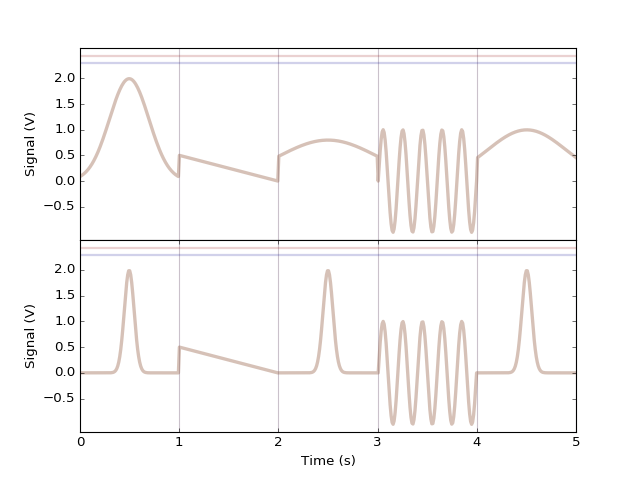

In [12]:
gaussian = pb.PulseAtoms.gaussian

# we make a blueprint with some gaussians
gbp = pb.BluePrint([gaussian, ramp, gaussian, sine, gaussian],
                   [(1, 0.2, 0, 0), (-0.5, 0.5), (1, 0.5, 0, 0), (5, 1, 0), (1, 0.4, 0, 0)],
                   ['', '', '', '', ''])

# and realise that all sigmas where way too large...
# Make the gaussians thinner and smaller
gbp2 = gbp.copy()
gbp2.changeArg('gaussian', 'sigma', 0.05, replaceeverywhere=True)
gbp2.changeArg('gaussian', 'ampl', 0.25, replaceeverywhere=True)
pb.bluePrintPlotter([gbp, gbp2], SR, [1, 1, 1, 1, 1])

<IPython.core.display.Javascript object>


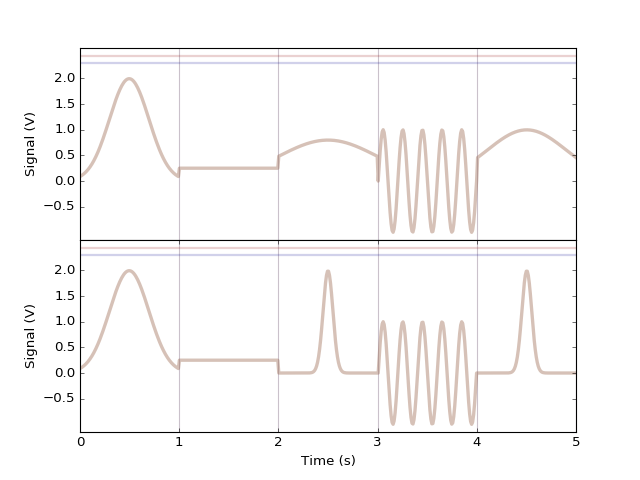

In [13]:
# The 'replaceeverywhere' looks for similar names, so naming can be used to discriminate 

# we make a blueprint with some gaussians
gbp = pb.BluePrint([gaussian, ramp, gaussian, sine, gaussian],
                   [(1, 0.2, 0, 0), (0, 0.25), (1, 0.5, 0, 0), (5, 1, 0), (1, 0.4, 0, 0)],
                   ['badgauss', '', 'goodgauss', '', 'goodgauss'])

# and realise that all sigmas where way too large...
# Make the gaussians thinner and smaller
gbp2 = gbp.copy()
gbp2.changeArg('goodgauss', 'sigma', 0.05, replaceeverywhere=True)
gbp2.changeArg('goodgauss', 'ampl', 0.25, replaceeverywhere=True)
pb.bluePrintPlotter([gbp, gbp2], SR, [1, 1, 1, 1, 1])

### Using the 'waituntil' special function

<IPython.core.display.Javascript object>


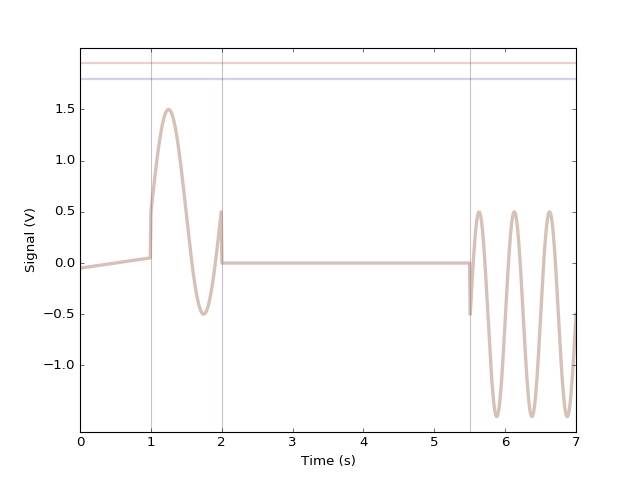

In [14]:
# The 'waituntil' function is utilised by adding the string 'waituntil' as a function. The corresponding argument
# is the ABSOLUTE time at which the NEXT segment should begin

bpwait = pb.BluePrint([ramp, sine, 'waituntil', sine],
                      [(0.1, -0.05), (1, 1, 0.5), (5.5,), (2, 1, -0.5)],
                      ['', '', '', ''])

# When plotting/forging, no duration should be specified for the 'waituntil' segment
pb.bluePrintPlotter(bpwait, SR, [1, 1, None, 1.5])


In [15]:
bpwait.getLength(SR, [1, 1, None, 1.5])

700

### Binding markers to specific segments

<IPython.core.display.Javascript object>


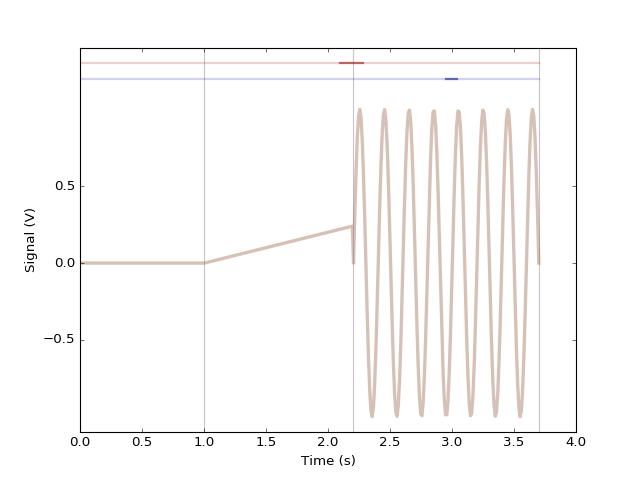

<IPython.core.display.Javascript object>


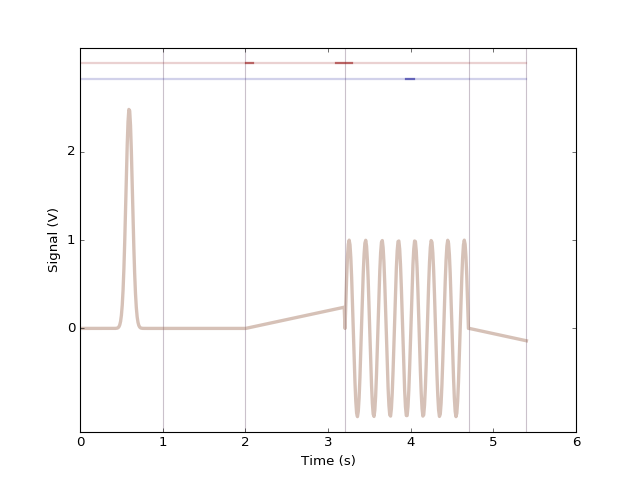

In [16]:
# It might be useful to have a marker indicating that some segment has been (or will soon be) reached

bp = pb.BluePrint([], [], [])
bp.insertSegment(0, ramp, (0, 0))
bp.insertSegment(1, ramp, (0.2, 0))
bp.insertSegment(2, sine, (5, 1, 0))  # This is the important segment
# make marker 1 go ON a bit before the sine comes on
bp.setSegmentMarker('sine', (-0.1, 0.2), 1)  # segment name, (delay, duration), markerID
# make marker 2 go ON halfway through the sine
bp.setSegmentMarker('sine', (0.75, 0.1), 2)

durations = [1, 1.2, 1.5]
pb.bluePrintPlotter(bp, SR, durations)

# Now we realise that we forgot to insert some segments...
bp.insertSegment(0, gaussian, (0.25, 0.04, 0.1, 0))
bp.insertSegment(-1, ramp, (-0.2, 0))
# and that we want a marker at 2s
bp.marker1 = [(2, 0.1)]

# The markers for the sine are still correctly bound:
pb.bluePrintPlotter(bp, SR, [1] + durations + [0.7])

# NB: the two different ways of inputting markers will never directly conflict, since one only specifies when to turn 
# markers ON. It is up to the user to ensure that markers switch off again as expected, i.e. that different marker
# specifications do not overlap.

<IPython.core.display.Javascript object>


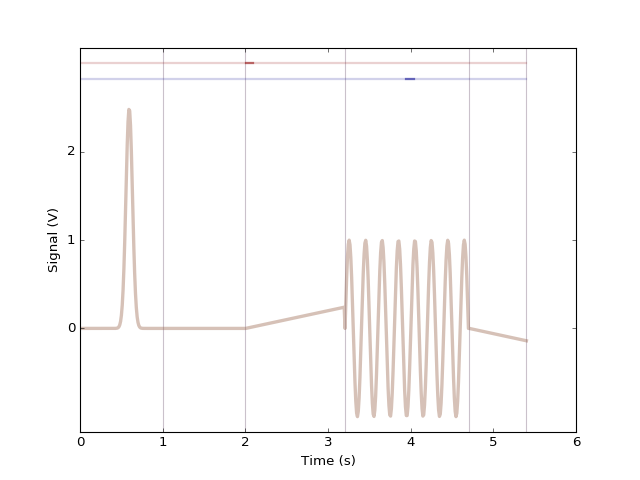

In [17]:
# The bound marker can be removed again
bp.removeSegmentMarker('sine', 1)
pb.bluePrintPlotter(bp, SR, [1] + durations + [0.7])

### Adding arbitrary segments

Custom-made python function can be added to a blueprint. The requirements are the following:
  
  * The function must take N+2 aedrguments, where N=0,1,2,... and where the last two arguments are SR and durations
  * Keyword arguments are not allowd
  * The function must return a list or an np.array with the functional values
  
Below an example

<IPython.core.display.Javascript object>


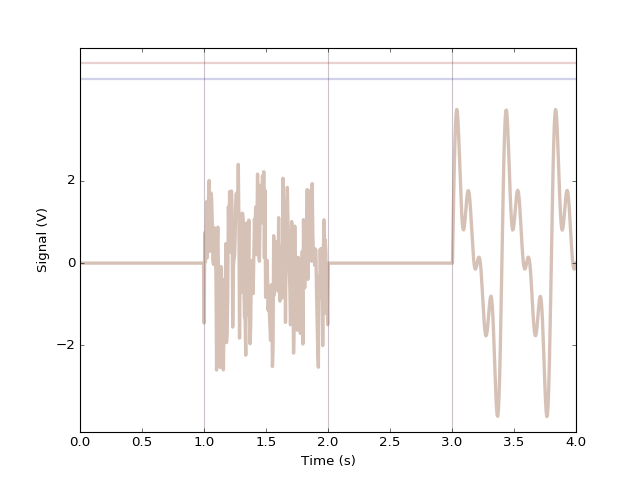

In [18]:
def noisy_sine(ampl, freq, SR, dur):
    N = int(np.round(SR*dur))
    time = np.linspace(0, dur, N)
    noise = np.random.randn(N)
    return list(ampl*np.sin(2*np.pi*freq*time)+noise)

def harmonics(basefreq, n, SR, dur):
    N = int(np.round(SR*dur))
    time = np.linspace(0, dur, N)
    output = np.sin(basefreq*2*np.pi*time)
    for ii in range(n):
        output += np.sin(ii*basefreq*2*np.pi*time)
    return output

custombp = pb.BluePrint([ramp, noisy_sine, ramp, harmonics],
                        [(0, 0), (1, 5), (0, 0), (2.5, 5)],
                        ['', '', '', ''])

pb.bluePrintPlotter(custombp, 200, [1, 1, 1, 1])